In [1]:
!pip install --upgrade imgaug
!pip install torchsummary

import torch, torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import time, cv2, glob, numpy as np, pandas as pd

## Helper functions
def stem(fpath): return '.'.join(fname(fpath).split('.')[:-1])
fname = lambda fpath: fpath.split('/')[-1]
def read(fname, mode=1):
    'load image from `fname` and convert it to right channel order'
    img = cv2.imread(str(fname), mode)
    if mode == 1: img = img[...,::-1] # BGR to RGB
    return img
def show(image, sz, title):
    'show an image with `sz` '
    try:
        if isinstance(image, torch.Tensor): image = image.cpu().numpy()
    except: ...
    image = np.copy(image)
    if image.max() == 255: image = image.astype(np.uint8)
    h, w = image.shape[:2]
    if isinstance(sz, int): sz = (sz, sz)
    fig, ax = plt.subplots(figsize=sz)
    ax.imshow(image)
    ax.set_title(title)
    plt.show()
    
    
info = lambda report: '\t'.join([f'{k}: {v:.3f}' for k,v in report.items()])
def report_metrics(pos, **report):
    '''Report training and validation metrics
    Required variables to be initialized before calling this function:
    1. start (time.time())
    2. n_epochs (int)
    
    Special kwargs:
    1. end - line ending after print (default newline)
    2. log - prefix info before printing summary
    
    Special argument:
    1. pos - position in training/testing process - float between 0 - n_epochs
    
    Usage:
    report_metrics(pos=1.42, train_loss=train_loss, validation_loss=validation_loss, ... )
    where each kwarg is a float
    '''
    elapsed = time.time()-start
    end = report.pop('end','\n')
    log = report.pop('log', ''); log = log+': ' if log!='' else log
    elapsed = '\t({:.2f}s - {:.2f}s remaining)'.format(time.time()-start, ((n_epochs-pos)/pos)*elapsed)
    current_iteration = f'EPOCH: {pos:.3f}\t'
    print(log + current_iteration + info(report) + elapsed, end=end)

Requirement already up-to-date: imgaug in /home/yyr/anaconda3/lib/python3.7/site-packages (0.4.0)


In [4]:
from imgaug import augmenters as iaa

train_data_dir = '/home/yyr/data/cat-and-dog/training_set/training_set/'
test_data_dir = '/home/yyr/data/cat-and-dog/test_set/test_set/'

IMAGE_SIZE = 224
train_transform = iaa.Sequential([
    iaa.geometric.Affine(translate_px=(0,10), rotate=(-10,10), mode='reflect'),
    iaa.flip.Fliplr(0.5),
    iaa.PadToAspectRatio(1.0, pad_mode='reflect'),
    iaa.contrast.LinearContrast(),
    iaa.Sometimes(0.5, [iaa.GaussianBlur(),
                        iaa.AdditiveGaussianNoise(loc=0, 
                                                  scale=(0.0, 0.05*255), 
                                                  per_channel=0.5)]),
    iaa.size.Resize(IMAGE_SIZE),
])
validation_transform = iaa.Sequential([
    iaa.PadToAspectRatio(1.0, pad_mode='reflect'),
    iaa.size.Resize(IMAGE_SIZE),
])


class FilePathDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform, N=None):
        cats = glob.glob(data_dir+'/cats/*.jpg')
        dogs = glob.glob(data_dir+'/dogs/*.jpg')
        self.fpaths = cats + dogs
        
        from random import shuffle, seed
        seed(10); shuffle(self.fpaths)
        
        self.targets = [stem(fpath).startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
        
        self.N = len(self.fpaths) if N is None else N
        self.transform = transform
        
    def class_balance(self): return np.mean(self.targets)
    def __len__(self): return self.N
    def __getitem__(self, ix):
        im = read(self.fpaths[ix], 1)
        im = self.transform.augment_image(im)
        im = torch.tensor(im)
        im = im.permute(2, 0, 1) # HWC to CHW
        return im/255., self.targets[ix]
    
dataset = FilePathDataset(train_data_dir, transform=train_transform, N=3000)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16)

dataset = FilePathDataset(test_data_dir, transform=validation_transform, N=100)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=16)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}\n')
print(f'''Train\t\t{len(train_loader.dataset)} examples
Validation\t{len(test_loader.dataset)} examples
Image Size\t{train_loader.dataset[0][0].shape}
Train Class balance:\t{train_loader.dataset.class_balance():.3f}
Test Class balance:\t{test_loader.dataset.class_balance():.3f}''')

Using device: cuda

Train		3000 examples
Validation	100 examples
Image Size	torch.Size([3, 224, 224])
Train Class balance:	0.500
Test Class balance:	0.500


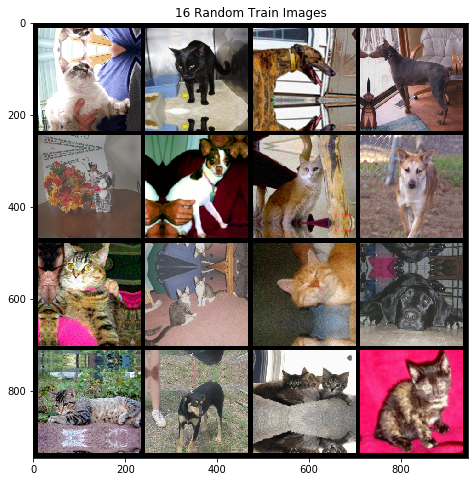

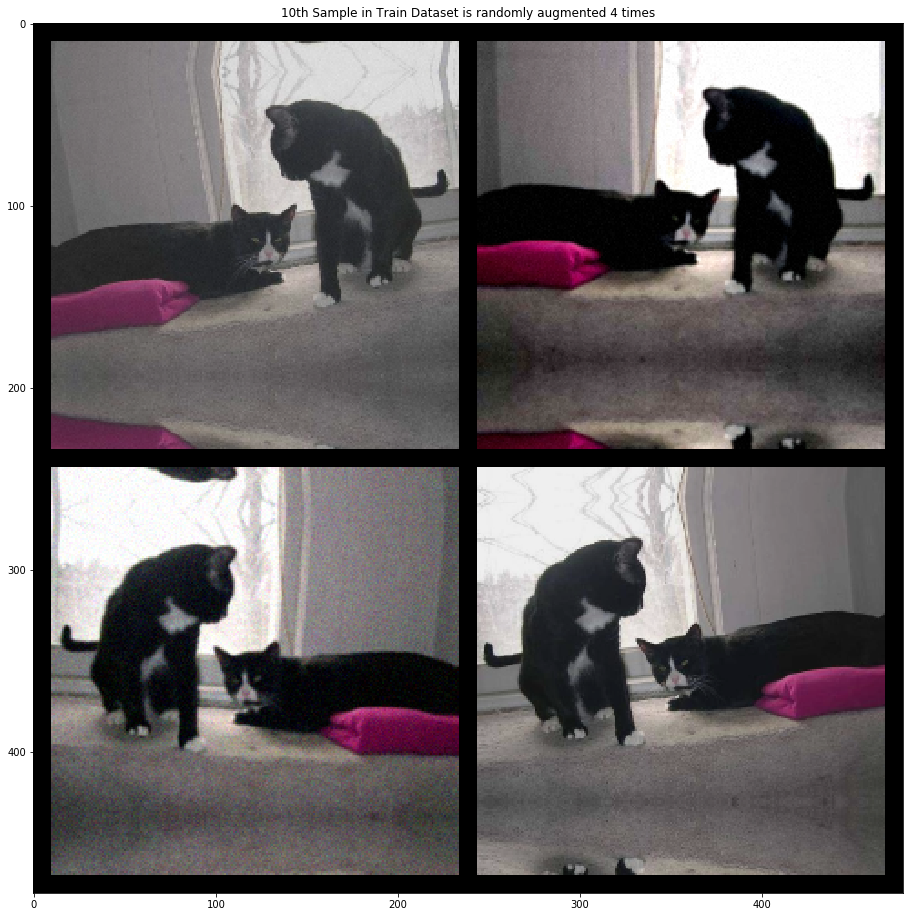

In [5]:
# Let's fetch the images from indexes given by `ixs` and plot them in a grid
def show_grid(ixs, dataloader, sz, title):
    inputs, classes = zip(*[dataloader.dataset[ix] for ix in ixs])
    inputs = torch.stack(inputs)
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs, scale_each=True, nrow=int(np.sqrt(len(inputs))), padding=10)
    # and see
    show(out.numpy().transpose((1, 2, 0)), sz=sz, title=title)
    
show_grid(np.random.randint(0, 100, size=16), train_loader, sz=8, title='16 Random Train Images')
# dogs and cats still look like dogs and cats. Notice the automatic rotation of images

# let's plot the 10th image 16 times from dataloader and plot. 
show_grid([10]*4, train_loader, sz=16, title='10th Sample in Train Dataset is randomly augmented 4 times')
# notice how the same image is being loaded differently everytime. 
# this way we get infinite variations of the same cat thereby making the model very generalized

In [6]:
class Identity(nn.Module):
    def __init__(self)  :  super(Identity, self).__init__()
    def forward(self, x):  return x
    
def conv_layer(ni,no,kernel_size,pool_size, stride=1,drop=0.2,bn=True,padding='same'):
    padding = 1 if kernel_size==3 else 0
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(pool_size) if pool_size is not None else Identity(),
        nn.BatchNorm2d(no) if bn else Identity(),
        nn.Dropout(drop) if drop is not None else Identity()
    )
def get_model(**kwargs):
    model = nn.Sequential(
        conv_layer(3, 64, 3, pool_size=None, stride=2),
        conv_layer(64, 64, 3, pool_size=None, stride=2),
        conv_layer(64, 128, 3, pool_size=None, stride=2),
        conv_layer(128, 256, 3, pool_size=None, stride=2),
        conv_layer(256, 256, 3, pool_size=None, stride=2),
        conv_layer(256, 512, 3, pool_size=None, stride=2),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid(),
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs.get('lr', 1e-3))
    return model, loss_fn, optimizer

try:
    from torchsummary import summary
except:
    !pip install torchsummary
    from torchsummary import summary

model, criterion, optimizer = get_model()
summary(model, input_size=(3,IMAGE_SIZE,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
              ReLU-2         [-1, 64, 112, 112]               0
          Identity-3         [-1, 64, 112, 112]               0
       BatchNorm2d-4         [-1, 64, 112, 112]             128
           Dropout-5         [-1, 64, 112, 112]               0
            Conv2d-6           [-1, 64, 56, 56]          36,928
              ReLU-7           [-1, 64, 56, 56]               0
          Identity-8           [-1, 64, 56, 56]               0
       BatchNorm2d-9           [-1, 64, 56, 56]             128
          Dropout-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 28, 28]          73,856
             ReLU-12          [-1, 128, 28, 28]               0
         Identity-13          [-1, 128, 28, 28]               0
      BatchNorm2d-14          [-1, 128,

In [7]:
def train_batch(x, y, model, opt, loss_fn):
    x, y = x.to(device), y.to(device).float().squeeze()
    model.train()
    prediction = model(x).squeeze()
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct.cpu().numpy().reshape(-1)

def validate_batch(x, y, model, loss_fn):
    x, y = x.to(device), y.to(device).float().squeeze()
    with torch.no_grad():
        model.eval()
        prediction = model(x).squeeze()
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_fn(prediction, y)
    return batch_loss.item(), is_correct.cpu().numpy().reshape(-1)

In [9]:
n_epochs = 40
model_save_path = 'models/stride-2.pth'

model, loss_fn, optimizer = get_model()
start = time.time()
best_test_accuracy = -1

for ex in range(n_epochs):
    N = len(train_loader)
    train_losses, train_corrects = [], []
    for bx, (x, y) in enumerate(train_loader):
        loss, corrects = train_batch(x, y, model, optimizer, loss_fn)
        train_losses.append(loss)
        train_corrects.extend(corrects)
        report_metrics(ex + ((bx+1)/N), train_loss=loss, train_acc=np.mean(train_corrects)*100, log='TRAIN', end='\r')
        
    N = len(test_loader)
    test_losses, test_corrects = [], []
    for bx, (x, y) in enumerate(test_loader):
        loss, corrects = validate_batch(x, y, model, loss_fn)
        test_losses.append(loss)
        test_corrects.extend(corrects)
        report_metrics(ex + ((bx+1)/N), test_loss=loss, test_acc=np.mean(test_corrects)*100, log='TEST', end='\r')
        
    train_acc = np.mean(train_corrects)*100
    test_acc = np.mean(test_corrects)*100
    if best_test_accuracy < test_acc:
        best_test_accuracy = test_acc
        torch.save(model, model_save_path)
        
    report_metrics(ex + 1, train_loss=np.mean(train_losses), train_acc=train_acc, 
                   test_loss=np.mean(test_losses), test_acc=test_acc, best_test_accuracy=best_test_accuracy,
                   end='\n')

EPOCH: 1.000	train_loss: 0.698	train_acc: 53.267	test_loss: 0.638	test_acc: 62.000	best_test_accuracy: 62.000	(63.54s - 2477.87s remaining)


/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Identity. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


EPOCH: 2.000	train_loss: 0.677	train_acc: 56.967	test_loss: 0.613	test_acc: 69.000	best_test_accuracy: 69.000	(105.31s - 2000.95s remaining)
EPOCH: 3.000	train_loss: 0.672	train_acc: 56.867	test_loss: 0.662	test_acc: 64.000	best_test_accuracy: 69.000	(141.64s - 1746.88s remaining)
EPOCH: 4.000	train_loss: 0.663	train_acc: 59.000	test_loss: 0.643	test_acc: 65.000	best_test_accuracy: 69.000	(178.05s - 1602.46s remaining)
EPOCH: 5.000	train_loss: 0.658	train_acc: 59.700	test_loss: 0.684	test_acc: 59.000	best_test_accuracy: 69.000	(214.65s - 1502.53s remaining)
EPOCH: 6.000	train_loss: 0.654	train_acc: 60.200	test_loss: 0.632	test_acc: 65.000	best_test_accuracy: 69.000	(250.85s - 1421.49s remaining)
EPOCH: 7.000	train_loss: 0.643	train_acc: 62.267	test_loss: 0.654	test_acc: 55.000	best_test_accuracy: 69.000	(285.25s - 1344.77s remaining)
EPOCH: 8.000	train_loss: 0.642	train_acc: 61.300	test_loss: 0.621	test_acc: 64.000	best_test_accuracy: 69.000	(321.71s - 1286.85s remaining)
EPOCH: 9.000	